In [1]:
import uproot
import h5py
import numpy as np
import os
import re
import awkward as awk
import heplot as hepl
import matplotlib.pyplot as plt
import importlib
import glob
from heplot import plotting as heplt
import sys
sys.path.append('..')

In [2]:
import src.selection as sele
import src.string_constants as stco
import src.generator as gene
import src.reader as read
import src.util as util

# generate samples

## MC

In [3]:
feature_names_in = ['el_e','mu_e','el_charge','mu_charge','el_pt','mu_pt', 'el_phi','mu_phi',\
                    'el_eta', 'mu_eta', 'jet_e', 'jet_pt', 'jet_truthflav',\
                	'weight_mc', 'weight_pileup', 'weight_jvt', 'weight_leptonSF']
feature_names_out = ['jet_pt_lead','jet_truthflav_lead',\
                	'weight_mc', 'weight_pileup', 'weight_jvt', 'weight_leptonSF']

In [4]:
ds_ids_sig_bg = sum(list(stco.ds_ids_sig.values()),[])+list(stco.ds_ids_bg.values())

In [5]:
paths = [glob.glob(os.path.join(stco.in_dir_mc,'*'+ds_id+'*')) for ds_id in ds_ids_sig_bg]
paths = sum(paths,[])
N = int(1e3)

In [6]:
paths

['/eos/atlas/atlascerngroupdisk/perf-flavtag/calib/negtag/Rel24_GN2v01/Ntuples_Nominal/mc20d/user.ltoffoli.mc20_13T.506193.MGPy8EG_Zee_FxFx_3jets_HT2bias_BF.D_FTAG2.e8382_s3681_r13144_p5981.GN2v01_Nom_output.root',
 '/eos/atlas/atlascerngroupdisk/perf-flavtag/calib/negtag/Rel24_GN2v01/Ntuples_Nominal/mc20d/user.ltoffoli.mc20_13T.506194.MGPy8EG_Zee_FxFx_3jets_HT2bias_CFBV.D_FTAG2.e8382_s3681_r13144_p5981.GN2v01_Nom_output.root',
 '/eos/atlas/atlascerngroupdisk/perf-flavtag/calib/negtag/Rel24_GN2v01/Ntuples_Nominal/mc20d/user.ltoffoli.mc20_13T.506195.MGPy8EG_Zee_FxFx_3jets_HT2bias_CVBV.D_FTAG2.e8382_s3681_r13144_p5981.GN2v01_Nom_output.root',
 '/eos/atlas/atlascerngroupdisk/perf-flavtag/calib/negtag/Rel24_GN2v01/Ntuples_Nominal/mc20d/user.ltoffoli.mc20_13T.506196.MGPy8EG_Zmumu_FxFx_3jets_HT2bias_BF.D_FTAG2.e8382_s3681_r13144_p5981.GN2v01_Nom_output.root',
 '/eos/atlas/atlascerngroupdisk/perf-flavtag/calib/negtag/Rel24_GN2v01/Ntuples_Nominal/mc20d/user.ltoffoli.mc20_13T.506197.MGPy8EG_Zmu

In [7]:
generator = gene.sample_generator(paths, N, selection_fun=sele.select_lightjets, feature_names_in=feature_names_in, feature_names_out=feature_names_out)

In [8]:
samples = None
i = 0

for sample_batch in generator:

    if samples is None:
        samples = sample_batch
    else:
        samples = awk.concatenate([samples,sample_batch])

    i = i+1
    if i > 20:
        break

print(f'{len(samples)} samples read')

21000 samples read


In [9]:
samples['wt'] = util.compute_mc_event_weights(samples)

In [10]:
jetU, jetC, jetB, jetT = util.split_by_jet_flavor(samples)

In [11]:
jetU, jetUNot = util.split_light_vs_nonlight_jet(samples)

In [12]:
all(jetU.jet_truthflav_lead == 0)

True

In [13]:
all(jetUNot.jet_truthflav_lead != 0)

True

In [14]:
jetU

<Array [{jet_pt_lead: 1.64e+05, ...}, ...] type='9157 * ?{jet_pt_lead: ?flo...'>

In [15]:
jetU.type.show()

9157 * ?{
    jet_pt_lead: ?float32,
    jet_truthflav_lead: ?int32,
    weight_mc: float32,
    weight_pileup: float32,
    weight_jvt: float32,
    weight_leptonSF: float32,
    wt: float32
}


In [24]:
len(awk.to_numpy(jetU).data)

9157

In [19]:
import pandas as pd
df_jetU = awk.to_dataframe(jetU)

TypeError: Iterator operand 1 dtype could not be cast from dtype([('jet_pt_lead', '?'), ('jet_truthflav_lead', '?'), ('weight_mc', '?'), ('weight_pileup', '?'), ('weight_jvt', '?'), ('weight_leptonSF', '?'), ('wt', '?')]) to dtype('bool') according to the rule 'unsafe'

This error occurred while calling

    ak.to_dataframe(
        <Array [{jet_pt_lead: 1.64e+05, ...}, ...] type='9157 * ?{jet_pt_le...'>
    )

## Data

In [17]:
feature_names_in = ['jet_pt', 'jet_e','el_e','mu_e', 'el_pt', 'el_eta', 'el_phi', 'el_charge', 'mu_pt', 'mu_eta', 'mu_phi', 'mu_charge']
feature_names_out = ['jet_pt_lead']

In [18]:
generator_data = gene.sample_generator([stco.in_dir_data], N, selection_fun=sele.select_lightjets, feature_names_in=feature_names_in, feature_names_out=feature_names_out)

In [19]:
samples_data = None
i = 0

for sample_batch in generator_data:

    if samples_data is None:
        samples_data = sample_batch
    else:
        samples_data = awk.concatenate([samples_data,sample_batch])

    i = i+1
    if i > 20:
        break

print(f'{len(samples_data)} data samples read')

139413 data samples read


In [20]:
samples_data

<Array [{jet_pt_lead: [9.54e+04]}, ..., {...}] type='139413 * {jet_pt_lead:...'>

# PLOT

In [24]:
ZUpt,ZCpt,ZBpt,Ztpt = awk.flatten(jetU.jet_pt_lead),awk.flatten(jetC.jet_pt_lead),awk.flatten(jetB.jet_pt_lead),awk.flatten(jetT.jet_pt_lead)
weights = [jetC.wt, jetB.wt, jetT.wt, jetU.wt]

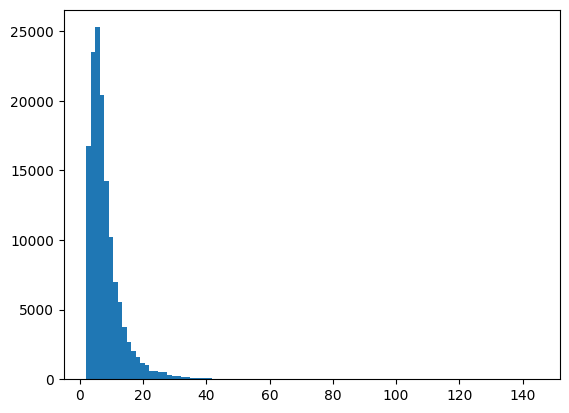

In [22]:
n_dat, bins_dat, patches = plt.hist(samples_data.jet_pt_lead/10000.,100)
bins_mean = [0.5 * (bins_dat[i] + bins_dat[i+1]) for i in range(len(n_dat))]

ValueError: x and y must be the same size

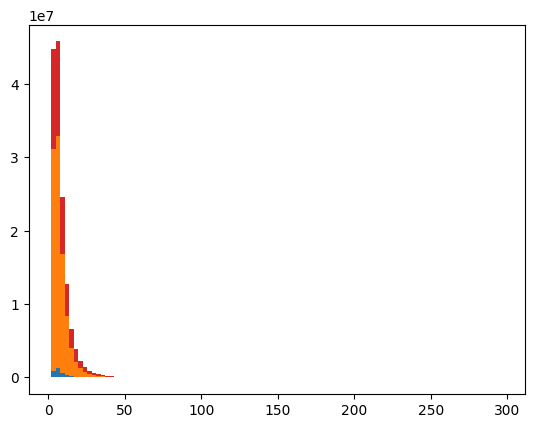

In [29]:
plt.figure()
n, bins, patches = plt.hist([ZCpt/10000.,ZBpt/10000.,Ztpt/10000.,ZUpt/10000.], 100, stacked=True, weights=weights)
n_dat, bins_dat, patches = plt.hist(samples_data.jet_pt_lead/10000.,100)

plt.scatter(bins_mean, n)
plt.legend(labels=['Z+charm','Z+b','Z+tau','Z+light'])
plt.yscale('log')
